In [2]:
from datetime import datetime, timedelta
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
datelist = pd.date_range(datetime.today(), periods=100).tolist()
from time import sleep
import dask.dataframe as dd
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import os
import glob
from datetime import date

from uuid import uuid4


from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import geopandas as gpd
import seaborn as sns

import dask.dataframe as dd
import geopandas as gpd
from detect_heatwaves import detect
from datetime import timedelta
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt



In [3]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/france/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df = full_df[~full_df['month'].isin([4, 10])]
full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


## Find heat waves, heat wave lengths and assign unique heatwave IDs

In [4]:
full_df['datetime'].min()

Timestamp('2018-05-01 00:00:00')

In [5]:
full_df['datetime'].min()

Timestamp('2018-05-01 00:00:00')

In [6]:
full_df['pct'] = full_df.groupby('location')['thi'].transform(lambda x: x.rank(pct=True))

In [7]:
#create dictionary containing each county's heatwave periods
heatwave_dic = {}
for adm2 in full_df['location'].unique():
    adm2_df = full_df[(full_df['location'] == adm2)]
    adm2_df.reset_index(inplace=True)
    adm2_df = adm2_df.sort_values(by='datetime')
    adm2_df.drop_duplicates(['adm2', 'datetime'], inplace=True)
    heatwave_dic[adm2] = detect(adm2_df['datetime_ord'].values, adm2_df['thi'].values, pctile=90, minDuration=2)

    
heatwave_dates = {}
consec_dates = {}
heatwave_IDs = {}
for adm2 in heatwave_dic.keys(): 
    consec_dates[adm2] = {}
    heatwave_dates[adm2] = []
    heatwave_IDs[adm2] = {}


    heatwave_starts = heatwave_dic[adm2]['date_start']
    heatwave_ends = heatwave_dic[adm2]['date_end']
    for i in range(len(heatwave_starts)):
        heatwave_code = str(uuid4())
        heatwave_days = pd.date_range(heatwave_starts[i],heatwave_ends[i],freq='d')
        length_heatwaves = len(heatwave_days)
        consec_dates[adm2][heatwave_days[0]] = length_heatwaves
        for item in heatwave_days:
            heatwave_dates[adm2].append(item)
            heatwave_IDs[adm2][item] = heatwave_code
            
            
heat_df = pd.DataFrame.from_dict(heatwave_dates, orient='index').unstack().reset_index()
heat_df.rename(columns={'level_1':'location', 0:'datetime'}, inplace=True)


heat_df.dropna(inplace=True)
heat_df['heatwave']=1

In [8]:
full_df

,Unnamed: 0,datetime,number,spatial_ref,t2m,d2m,rh,thi,adm2,adm1,day,month,year,location,datetime_ord,pct
0,0,2018-05-01,0.0,0.0,12.984543,3.212509,72.96763,11.467585,Bas-Rhin,Alsace,1,5,2018,"Bas-Rhin, Alsace",736815,0.018301
1,1,2018-05-02,0.0,0.0,16.846756,8.483494,82.40495,15.875832,Bas-Rhin,Alsace,2,5,2018,"Bas-Rhin, Alsace",736816,0.117647
2,2,2018-05-03,0.0,0.0,16.842527,7.163579,81.98801,15.847073,Bas-Rhin,Alsace,3,5,2018,"Bas-Rhin, Alsace",736817,0.113725
3,3,2018-05-04,0.0,0.0,20.003017,9.834668,72.43605,19.402456,Bas-Rhin,Alsace,4,5,2018,"Bas-Rhin, Alsace",736818,0.270588
4,4,2018-05-05,0.0,0.0,22.701967,11.183942,65.62170,22.267851,Bas-Rhin,Alsace,5,5,2018,"Bas-Rhin, Alsace",736819,0.469281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74393,74393,2022-09-26,0.0,0.0,9.025503,3.669450,98.37174,7.805842,Savoie,Rhône-Alpes,26,9,2022,"Savoie, Rhône-Alpes",738424,0.084967
74394,74394,2022-09-27,0.0,0.0,5.570193,2.507942,96.72386,4.936991,Savoie,Rhône-Alpes,27,9,2022,"Savoie, Rhône-Alpes",738425,0.028758
74395,74395,2022-09-28,0.0,0.0,7.894247,6.730359,97.35292,7.502293,Savoie,Rhône-Alpes,28,9,2022,"Savoie, Rhône-Alpes",738426,0.075817
74396,74396,2022-09-29,0.0,0.0,6.146764,4.305479,97.17700,5.682936,Savoie,Rhône-Alpes,29,9,2022,"Savoie, Rhône-Alpes",738427,0.036601


In [9]:
full_df['datetime'] = pd.to_datetime(full_df['datetime'])

In [10]:
full_df = full_df.merge(heat_df, on=['location', 'datetime'], how='left')

full_df['heatwave'] = full_df['heatwave'].replace(np.nan, 0)

In [11]:
full_df[full_df['heatwave'] == 1]['pct'].min()

0.9006535947712418

In [12]:
len(full_df[full_df['heatwave'] == 1]['location'].unique())

96

In [13]:
codes = pd.DataFrame.from_dict(heatwave_IDs, orient='index').unstack().reset_index()

In [14]:
codes.columns=['datetime', 'location', 'heat_ID']

In [15]:
codes.dropna(inplace=True)

In [16]:
codes

,datetime,location,heat_ID
0,2018-07-24,"Bas-Rhin, Alsace",076f30bc-6382-4a21-a479-597372f950c3
1,2018-07-24,"Haut-Rhin, Alsace",0b2fe3f9-a12a-4440-9214-5a187ac34344
2,2018-07-24,"Hauts-de-Seine, Île-de-France",04352367-ccad-49e9-a5be-4283ca10bf3c
3,2018-07-24,"Paris, Île-de-France",b95e5a5d-a28b-4669-aec6-9a0502c18e7a
4,2018-07-24,"Seine-et-Marne, Île-de-France",d5f4e4e8-39f6-4f99-982b-22767b018a36
...,...,...,...
19610,2022-08-15,"Nord, Nord-Pas-de-Calais",fcd380ca-7979-469a-aee3-47177852def1
19611,2022-08-15,"Pas-de-Calais, Nord-Pas-de-Calais",eb3993fb-e230-4f6f-8fe4-f7faf905dd1a
19753,2018-07-28,"Var, Provence-Alpes-Côte d'Azur",415d7607-19cd-4be3-a44c-2ac54f79a272
19843,2020-07-09,"Ardèche, Rhône-Alpes",c9b4ce76-56de-4d3f-93ef-e96979a25170


In [17]:
consec = pd.DataFrame.from_dict(consec_dates, orient='index').unstack().reset_index()

In [18]:
consec.columns= ['datetime', 'location', 'Heat Wave Duration']

In [19]:
consec['Heat Wave Duration'].max()

14.0

In [20]:
consec.dropna(inplace=True)

In [21]:
consec

,datetime,location,Heat Wave Duration
0,2018-07-24,"Bas-Rhin, Alsace",4.0
1,2018-07-24,"Haut-Rhin, Alsace",4.0
2,2018-07-24,"Hauts-de-Seine, Île-de-France",4.0
3,2018-07-24,"Paris, Île-de-France",4.0
4,2018-07-24,"Seine-et-Marne, Île-de-France",4.0
...,...,...,...
11987,2019-06-28,"Somme, Picardie",2.0
12027,2022-08-05,"Bouches-du-Rhone, Provence-Alpes-Côte d'Azur",2.0
12189,2018-07-28,"Var, Provence-Alpes-Côte d'Azur",10.0
12285,2020-08-11,"Var, Provence-Alpes-Côte d'Azur",2.0


In [22]:
full_df = full_df.merge(codes, on=['datetime', 'location'])

In [23]:
full_df = full_df.merge(consec, on=['datetime', 'location'], how='left')

In [24]:
full_2022 = full_df[full_df['year'] == 2022]

In [25]:
full_df['heat_ID'].value_counts()

b23f996b-36b6-41a8-96d2-a2fb329f04bf    14
b9714251-4126-489c-9459-cebffc9ab1f3    14
33b5f77d-e2e0-4236-8e5d-c8b98fc044ff    13
142ef1f7-347c-404e-9d73-7cd4b6cae548    13
340f01cd-c6a8-48e3-ba67-42cd6db480aa    13
                                        ..
83f53ccf-d823-4a48-b5e0-eb11cca1bd29     2
17310330-f87f-42f1-8b89-a6ef7db5886a     2
9372ada4-414f-495a-bd7d-ec27ef777e85     2
66b74b10-3f6f-4b79-b2c4-fc6d8eb9a4a2     2
42e9418f-8309-4e1c-8c3f-db9c4700b854     2
Name: heat_ID, Length: 1610, dtype: int64

In [26]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/france/clean_shp.shp')

In [29]:
for_plot = gdf.merge(full_df.groupby(['adm2'])['thi'].mean().reset_index(), left_on=['adm2'], right_on=['adm2'])

Text(0.5, 1.0, 'France 2022 heatwave temperatures (THI)')

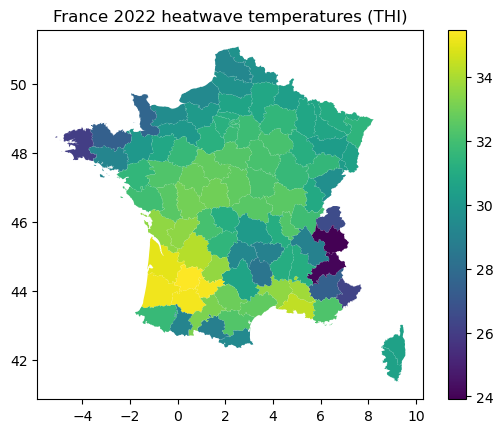

In [31]:
for_plot.plot(column='thi', legend=True)
plt.title("France 2022 heatwave temperatures (THI)")

In [35]:
len(full_2022['adm2'].unique())

96

In [36]:
#changed from v2
full_2022.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/france/THI_france_90_2022.csv')
full_df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/france/THI_france_90_2018_2022.csv')